## CNN 

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import Functions as func
import GetPickles
import var

Using plaidml.keras.backend backend.


In [2]:
def get_conv_model_normal(dim):
    
    inp_shape = dim
    act = 'relu'
    drop = .5 
    kernal_reg = regularizers.l1(.001)
    dil_rate = 2
    
    
    model = Sequential() 
    
    model.add(Conv2D(64, kernel_size=(3,3),activation=act, input_shape = inp_shape, 
                     kernel_regularizer = kernal_reg,
                     kernel_initializer = 'he_uniform',  padding = 'same', name = 'Input_Layer'))
    #model.add(Dense(64, activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),  strides = (2,2)))
    
    
    model.add(Conv2D(64, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    #model.add(Dense(64, activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))
    

    
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

    
    model.add(Flatten())

    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))


    model.add(Dropout(drop))

    model.add(Dense(1, activation='sigmoid', name = 'Output_Layer'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model 


In [3]:
x_train, x_test, y_train, y_test = GetPickles.get_samples('test')


In [4]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(7239, 96, 96, 3) (381, 96, 96, 3)
(7239, 1) (381, 1)


In [5]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator


augment = True 
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=18)
model_checkpoint = ModelCheckpoint('../models/CNN-ModelCheckpointWeights.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 3, mode = 'min')
epochs = 200
batch_size = 32
if var.img_type == 'grey': 
    dim = (x_train.shape[1], x_train.shape[2], 1)
else: 
    dim = (x_train.shape[1], x_train.shape[2], 3)
    
normal_model = get_conv_model_normal(dim =dim)

if augment: 
    augmentation =ImageDataGenerator(rotation_range = 15, width_shift_range = .1, height_shift_range = .1, 
                                                           horizontal_flip = True, fill_mode = 'nearest')
    augmentation.fit(x_train)
    normal_history = normal_model.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
                epochs = epochs, 
         callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)
else: 
    
    normal_history = normal_model.fit(x_train, y_train, batch_size = batch_size,
                epochs = epochs, 
         callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)


INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


Epoch 1/200
227/227 [==============================] - 46s 204ms/step - loss: 3.5895 - acc: 0.7716 - val_loss: 1.3131 - val_acc: 0.7953

Epoch 00001: val_loss improved from inf to 1.31312, saving model to ../models/CNN-ModelCheckpointWeights.h5
Epoch 2/200
227/227 [==============================] - 22s 96ms/step - loss: 0.9750 - acc: 0.8828 - val_loss: 0.9465 - val_acc: 0.8241

Epoch 00002: val_loss improved from 1.31312 to 0.94648, saving model to ../models/CNN-ModelCheckpointWeights.h5
Epoch 3/200
227/227 [==============================] - 22s 96ms/step - loss: 0.7740 - acc: 0.9001 - val_loss: 0.8761 - val_acc: 0.8241

Epoch 00003: val_loss improved from 0.94648 to 0.87608, saving model to ../models/CNN-ModelCheckpointWeights.h5
Epoch 4/200
227/227 [==============================] - 22s 97ms/step - loss: 0.7142 - acc: 0.9047 - val_loss: 0.7001 - val_acc: 0.8871

Epoch 00004: val_loss improved from 0.87608 to 0.70013, saving model to ../models/CNN-ModelCheckpointWeights.h5
Epoch 5/200

In [7]:
print(normal_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (Conv2D)         (None, 96, 96, 64)        1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 128)       0         
__________

## Loss & Accuracy

In [ ]:
train_loss = normal_history.history['loss']
train_acc = normal_history.history['acc']
test_loss = normal_history.history['val_loss']
test_acc = normal_history.history['val_acc']
epochs = [i for i in range(1, len(test_acc)+1)]

fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(epochs, train_loss, label = 'Train Loss')
ax[0].plot(epochs, test_loss, label = 'Test Loss')
ax[0].set_title('Train/Test Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, train_acc, label = 'Train Accuracy')
ax[1].plot(epochs, test_acc, label = 'Test Accuracy')
ax[1].set_title('Train/Test Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

In [ ]:
y_test.shape

### AUC and ROC Curves

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc

if var.img_type == 'grey': 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
    
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('../models/CNN-ModelCheckpointWeights.h5') #load the best weights before overfitting
 

fig, ax = plt.subplots(1,2, figsize = (15,6))
#AUC CURVE
y_test_prob = normal_model.predict(x_test)

y_test_precision, y_test_recall, spec = precision_recall_curve(y_test, y_test_prob)
y_test_predict = np.where(y_test_prob >= .5, 1, 0).ravel()
y_test_f1= f1_score(y_test, y_test_predict)
y_test_auc = auc(y_test_recall, y_test_precision)
no_skill = len(y_test[y_test==1]) / len(y_test)
ax[0].plot(y_test_recall, y_test_precision, marker='.', label='CNN')
ax[0].plot([0, 1], [no_skill, no_skill], linestyle='--', label='50/50', color = 'Black')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title(f'AUC Curve')
ax[0].legend()

#ROC CURVE
ns_probs = [0 for i in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
y_test_roc = roc_auc_score(y_test, y_test_prob)

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
y_test_fpr, y_test_tpr, threshold = roc_curve(y_test, y_test_prob)
ax[1].plot(ns_fpr, ns_tpr, linestyle='--', label='50/50')
ax[1].plot(y_test_fpr, y_test_tpr, marker='.', label='CNN')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title(f'ROC Curve')
ax[1].legend()
plt.show()

pd.DataFrame({'F1 Score': round(y_test_f1, 3), 'AUC': round(y_test_auc, 3), 'ROC':round(y_test_roc, 3)}, index = [0])

In [ ]:
df = pd.DataFrame({'Threshold': threshold, 'FPR': y_test_fpr, 'TPR': y_test_tpr})
plt.plot(df.Threshold, df.FPR, label = 'False Positive Rate')
plt.plot(df.Threshold, df.TPR, label = 'True Positive Rate')
plt.xlabel('Threshold')
plt.ylabel('FPR/TPR')
plt.title('Change in FPR/TPR with Threshold')
plt.xlim(0, 1)
plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
import itertools
import seaborn as sns
def plot_confusion_matrix(y_test,y_train, y_train_prob, y_test_prob,thresholds, classes,
                          cmap=plt.cm.Blues):
    fig, ax = plt.subplots(len(thresholds),2, figsize = (10,10))

    for idx, thresh in enumerate(thresholds):
        y_test_predict = np.where(y_test_prob >= thresh, 1, 0)
        y_train_predict = np.where(y_train_prob >= thresh, 1, 0)
        train_cm = confusion_matrix(y_train, y_train_predict) 
        test_cm = confusion_matrix(y_test, y_test_predict)
        
        #test confusion
        ax[idx, 0].imshow(test_cm,  cmap=plt.cm.Blues) 

        ax[idx, 0].set_title(f'Test: Confusion Matrix | Threshold: {thresh}')
        ax[idx, 0].set_ylabel('True label')
        ax[idx, 0].set_xlabel('Predicted label')

        class_names = classes 
        tick_marks = np.arange(len(class_names))
        ax[idx, 0].set_xticks(tick_marks)
        ax[idx,0].set_xticklabels(class_names)
        ax[idx, 0].set_yticks(tick_marks)
        ax[idx, 0].set_yticklabels(class_names)

        th = test_cm.max() / 2. 

        for i, j in itertools.product(range(test_cm.shape[0]), range(test_cm.shape[1])):
                ax[idx, 0].text(j, i, f'{test_cm[i, j]}',# | {int(round(test_cm[i,j]/test_cm.ravel().sum(),5)*100)}%',
                         horizontalalignment='center',
                         color='white' if test_cm[i, j] > th else 'black')
        ax[idx, 0].set_ylim([-.5,1.5])
        
        #TRAIN CONFUSION
        ax[idx, 1].imshow(train_cm,  cmap=plt.cm.Blues) 

        ax[idx, 1].set_title(f'Train: Confusion Matrix | Threshold: {thresh}')
        ax[idx, 1].set_ylabel('True label')
        ax[idx, 1].set_xlabel('Predicted label')

        class_names = classes 
        tick_marks = np.arange(len(class_names))
        ax[idx, 1].set_xticks(tick_marks)
        ax[idx,1].set_xticklabels(class_names)
        ax[idx, 1].set_yticks(tick_marks)
        ax[idx, 1].set_yticklabels(class_names)


        th = train_cm.max() / 2. 

        for i, j in itertools.product(range(train_cm.shape[0]), range(train_cm.shape[1])):
                ax[idx, 1].text(j, i, f'{train_cm[i, j]}',# | {int(round(train_cm[i,j]/train_cm.ravel().sum(),5)*100)}%',
                         horizontalalignment='center',
                         color='white' if train_cm[i, j] > th else 'black')
        ax[idx, 1].set_ylim([-.5,1.5])
    plt.tight_layout()
 
    plt.show()
if var.img_type == 'grey': 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
        
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('../models/CNN-ModelCheckpointWeights.h5') #load the best weights before overfitting

y_test_prob = normal_model.predict(x_test).ravel()

y_train_prob = normal_model.predict(x_train).ravel()

plot_confusion_matrix(y_train = y_train, y_test = y_test, y_train_prob = y_train_prob,
                      y_test_prob = y_test_prob,classes = ['No Weapon', 'Weapon'], thresholds = [.2, .5,.6])

In [ ]:
assert False

#### Test on Google Data


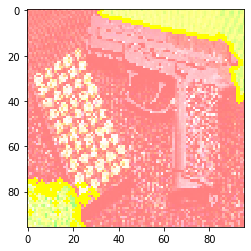

In [6]:
import cv2
from lime import lime_image
from skimage.segmentation import mark_boundaries

if var.img_type == 'grey': 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
        
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('../models/CNN-ModelCheckpointWeights.h5')
img = func.get_image_value('../test3.jpg', var.norm_dimension, var.img_type)

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(img, normal_model.predict, top_labels = 5, hide_color = 0, 
                                         num_samples = 1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only = False,
                                           num_features = 10, hide_rest = False)
plt.imshow(mark_boundaries(temp/2 + .5, mask))

In [ ]:
if var.img_type == 'grey': 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
        
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('../models/CNN-ModelCheckpointWeights.h5')

img = cv2.imread('../test3.jpg')
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process() 

windows = []
locations = []
for x, y, w,h in rects: 
    startx = x 
    starty = y 
    endx = x+w 
    endy = y+h 
    roi = img[starty:endy, startx:endx]
    roi = cv2.resize(roi, dsize =var.norm_dimension, interpolation = cv2.INTER_CUBIC)
    windows.append(roi)
    locations.append((startx, starty, endx, endy))
    


In [ ]:
windows = np.array(windows)

predictions = normal_model.predict(windows)

In [ ]:
# for i in predictions:
#     print(i)

In [ ]:
clone = img.copy()
new_loc = [] 
new_prob = [] 
for idx, i in enumerate(predictions): 
    if i != 1: 
        continue
    startx, starty, endx, endy = locations[idx]
    cv2.rectangle(clone, (startx, starty), (endx, endy),  (0,255,0),2)
    text = f'Weapon: {i*100}'
    cv2.putText(clone, text, (startx, y), cv2.FONT_HERSHEY_SIMPLEX, .45, (0,255,0),2)
    new_loc.append(locations[idx])
    new_prob.append(i[0])
    
cv2.imshow('test', clone)
cv2.waitKey(0)

In [ ]:
boxid = func.non_max_suppression(np.array(new_loc), np.array(new_prob))[0]
boxid

In [ ]:
clone = img.copy()
  
startx, starty, endx, endy = new_loc[boxid]
cv2.rectangle(clone, (startx, starty), (endx, endy),  (0,255,0),2)
text = f'Weapon: {i*100}'
cv2.putText(clone, text, (startx, y), cv2.FONT_HERSHEY_SIMPLEX, .45, (0,255,0),2)
cv2.imshow('test', clone)
cv2.waitKey(0)

In [ ]:
clone = img.copy()
roi = clone[starty:endy, startx:endx]
roi = cv2.resize(roi, dsize =var.dimension, interpolation = cv2.INTER_CUBIC)
# cv2.imshow('test', roi)
# cv2.waitKey(0)
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(roi, normal_model.predict, top_labels = 5, hide_color = 0, 
                                         num_samples = 1000)


temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only = False,
                                           num_features = 10, hide_rest = False)
plt.imshow(mark_boundaries(temp/2 + .5, mask))